In [1]:
# Import all necessary packages to run functions
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
from FlowCytometryTools import FCMeasurement
from FlowCytometryTools import QuadGate
import sklearn
from sklearn.decomposition import PCA


def importF(pathname):
    """Import FCS files. Variable input: name of path name to file. Output is a list of Data File Names in FCT Format"""
    # Declare arrays and int
    file = []
    sample = []
    z = 0
    # Read in user input for file path and assign to array file
    pathlist = Path(r"" + str(pathname)).glob("**/*.fcs")
    for path in pathlist:
        path_in_str = str(path)
        file.append(path_in_str)
    # Go through each file and assign the file contents to entry in the array sample
    for entry in file:
        sample.append(FCMeasurement(ID="Test Sample" + str(z), datafile=entry))
        z += 1
    importF.sample = sample
    # Returns the array sample which contains data of each file in folder (one file per entry in array)
    return sample


def sampleT(smpl):
    """Output is the T cells data (the protein channels related to T cells)"""
    # Features are the protein channels of interest when analyzing T cells
    features = ["BL1-H", "VL1-H", "VL4-H", "BL3-H"]
    # Transform to put on log scale
    tform = smpl.transform("hlog", channels=["BL1-H", "VL1-H", "VL4-H", "BL3-H", "RL1-H"])
    # Save the data of each column of the protein channels
    data = tform.data[["BL1-H", "VL1-H", "VL4-H", "BL3-H"]][0:]
    # Save pSTAT5 data
    pstat = tform.data[["RL1-H"]][0:]
    return data, pstat, features


def sampleNK(smpl):
    """Output is the NK cells data (the protein channels related to NK cells)"""
    # For NK, the data consists of different channels so the data var. output will be different
    # Output is data specific to NK cells
    # Features for the NK file of proteins (CD3, CD8, CD56)
    features = ["VL4-H", "RL1-H", "BL1-H"]
    # Transform all proteins (including pSTAT5)
    tform = smpl.transform("hlog", channels=["VL4-H", "RL1-H", "BL1-H", "BL2-H"])
    # Assign data of three protein channels AND pSTAT5
    data = tform.data[["VL4-H", "RL1-H", "BL1-H"]][0:]
    pstat = tform.data[["BL2-H"]][0:]
    return data, pstat, features


def appPCA(data, features):
    """Applies the PCA algorithm to the data set"""
    # Apply PCA to the data set
    # setting values of data of selected features to data frame
    xi = data.loc[:, features].values
    # STANDARDIZE DATA --> very important to do before applying machine learning algorithm
    xs = sklearn.preprocessing.scale(xi)
    xs = np.nan_to_num(xs)
    # setting how many components wanted --> PC1 and PC2
    pca = PCA(n_components=2)
    # apply PCA to standardized data set
    # NOTE: score == xf
    xf = pca.fit(xs).transform(xs)
    # creates the loading array (equation is defintion of loading)
    loading = pca.components_.T
    return xf, loading


def pcaPlt(xf, pstat, features, i):
    """
    Used to plot the score graph.
    Scattered point color gradients are based on range/abundance of pSTAT5 data. Light --> Dark = Less --> More Active
    """
    # PCA
    if len(features) == 4:
        name = "T Cells"
    elif len(features) == 3:
        name = "NK Cells"
    # Setting x and y values from xf
    x = xf[:, 0]
    y = xf[:, 1]
    # Working with pSTAT5 data --> setting min and max values
    pstat_data = pstat.values

    # Creating a figure for both scatter and mesh plots for PCA
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel("Principal Component 1", fontsize=15)
    ax.set_ylabel("Principal Component 2", fontsize=15)
    ax.set_title(name + " - PCA - File " + str(i), fontsize=20)
    ax.set(xlim=(-5, 5), ylim=(-5, 5))

    # This is the scatter plot of the cell clusters colored by pSTAT5 data
    # lighter --> darker = less --> more pSTAT5 present
    plt.scatter(x, y, s=0.1, c=np.squeeze(pstat_data), cmap="Greens")
    
    
def loadingPlot(loading, features, i):
    """Plot the loading data"""
    # Loading
    # Create graph for loading values
    x_load = loading[:, 0]
    y_load = loading[:, 1]

    # Create figure for the loading plot
    fig1 = plt.figure(figsize=(8, 8))
    ax = fig1.add_subplot(1, 1, 1)
    ax.set_xlabel("PC1", fontsize=15)
    ax.set_ylabel("PC2", fontsize=15)
    plt.scatter(x_load, y_load)

    for z, feature in enumerate(features):
        # Please note: not the best logic, but there are three features in NK and four features in T cells
        if len(features) == 4:
            name = "T Cells"
            if feature == "BL1-H":
                feature = "Foxp3"
            elif feature == "VL1-H":
                feature = "CD25"
            elif feature == "VL4-H":
                feature = "CD4"
            elif feature == "BL3-H":
                feature = "CD45RA"
        if len(features) == 3:
            name = "NK Cells"
            if feature == "VL4-H":
                feature = "CD3"
            if feature == "RL1-H":
                feature = "CD8"
            if feature == "BL1-H":
                feature = "CD56"
        plt.annotate(str(feature), xy=(x_load[z], y_load[z]))
    ax.set_title(name + " - Loading - File " + str(i), fontsize=20)
    
    
def pcaAll(sampleType, check):
    """
    Use to plot the score and loading graphs for PCA. Assign protein and pstat5 arrays AND score and loading arrays
    This is all the data for each file.
    Want to use for both T and NK cells? Use it twice!
    sampleType is importF for T or NK
    check == "t" for T cells OR check == "n" for NK cells
    """
    # declare the arrays to store the data
    data_array = []
    pstat_array = []
    xf_array = []
    loading_array = []
    # create the for loop to file through the data and save to the arrays
    # using the functions created above for a singular file
    if check == "t":
        for i, sample in enumerate(sampleType):
            data, pstat, features = sampleT(sample)
            data_array.append(data)
            pstat_array.append(pstat)
            xf, loading = appPCA(data, features)
            xf_array.append(xf)
            loading_array.append(loading)
            pcaPlt(xf, pstat, features, i)
            loadingPlot(loading, features, i)
    elif check == "n":
        for i, sample in enumerate(sampleType):
            data, pstat, features = sampleNK(sample)
            data_array.append(data)
            pstat_array.append(pstat)
            xf, loading = appPCA(data, features)
            pcaPlt(xf, pstat, features, i)
            loadingPlot(loading, features, i)
    plt.show()
    return data_array, pstat_array, xf_array, loading_array


/usr/local/lib/python3.7/dist-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)
/usr/local/lib/python3.7/dist-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)


What is the name of the T plate folder?: /home/heatherm/gating/Tall
What is the name of the NK plate folder?: /home/heatherm/gating/NKall


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were enc

[[-0.5089445   0.13188802]
 [-0.38530928 -0.90612066]
 [-0.55023795  0.14629695]
 [-0.53828496  0.37436423]]
[[-0.52915025  0.14030342]
 [-0.35685515 -0.9067598 ]
 [-0.54946715  0.06962141]
 [-0.5392034   0.39147708]]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


[[-0.48054773 -0.368647  ]
 [-0.48009825  0.66630393]
 [-0.55719143  0.25473136]
 [-0.47761607 -0.5960289 ]]
[[-0.52021974  0.06659269]
 [-0.34462613 -0.9185984 ]
 [-0.55421925  0.15236619]
 [-0.5508584   0.35850593]]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


[[-0.52664626  0.11723656]
 [-0.38518882 -0.8870419 ]
 [-0.53903735  0.086404  ]
 [-0.5326462   0.43811718]]
[[-0.5261462   0.12532501]
 [-0.35949117 -0.9162953 ]
 [-0.54438233  0.12339607]
 [-0.5455128   0.35981956]]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


[[-0.529039    0.01697601]
 [-0.34249455 -0.9118285 ]
 [-0.54841024  0.18734959]
 [-0.54960144  0.36493903]]
[[-0.5230195   0.17364378]
 [-0.44553    -0.82008123]
 [-0.50503176 -0.02000037]
 [-0.5223951   0.54489887]]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


[[-0.5220497   0.11191623]
 [-0.34327668 -0.92480433]
 [-0.5557661   0.1316343 ]
 [-0.5484059   0.33894596]]
[[-0.5215434   0.17850202]
 [-0.36452293 -0.90732366]
 [-0.5494611   0.06245255]
 [-0.54148716  0.37550035]]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: RuntimeWarnin

[[-0.5284166   0.1529172 ]
 [-0.3387857  -0.92817277]
 [-0.5473865   0.09856525]
 [-0.5535055   0.3246479 ]]
[[-0.5205938   0.21539338]
 [-0.37792885 -0.87010914]
 [-0.5514425  -0.03279313]
 [-0.531096    0.44208658]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: RuntimeWarnin

[[-0.4951201   0.40968198]
 [-0.4268905  -0.6990085 ]
 [-0.5670638  -0.28435826]
 [-0.50105774  0.5125313 ]]
[[-0.51791656  0.09729639]
 [-0.3726976  -0.91171217]
 [-0.5478326   0.1730302 ]
 [-0.54105294  0.35968724]]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-

[[-0.5234248   0.14628777]
 [-0.31667662 -0.9371713 ]
 [-0.5564342   0.08846208]
 [-0.5622482   0.30411178]]
[[-0.5197819   0.16577202]
 [-0.38756865 -0.8916533 ]
 [-0.5418657   0.06849509]
 [-0.53478885  0.41567126]]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: RuntimeWarnin

[[-0.52644515  0.19746009]
 [-0.36253935 -0.9052872 ]
 [-0.54500777  0.03904751]
 [-0.54257464  0.37408537]]
[[-0.5226903   0.04808046]
 [-0.3593464  -0.90903944]
 [-0.5504049   0.18035516]
 [-0.54288065  0.37256882]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: RuntimeWarnin

[[-0.5203474   0.21414673]
 [-0.3926491  -0.8817057 ]
 [-0.5381621   0.01932395]
 [-0.5342723   0.41995618]]
[[-0.5164686   0.08440445]
 [-0.35190094 -0.91712624]
 [-0.5544021   0.14511639]
 [-0.54960364  0.36151966]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-

[[-0.5222691   0.05006773]
 [-0.3527326  -0.9140281 ]
 [-0.5528245   0.18164095]
 [-0.5451604   0.3592391 ]]
[[-0.5143285   0.16390927]
 [-0.38857317 -0.89055663]
 [-0.5454492   0.06863329]
 [-0.5356885   0.4187268 ]]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: RuntimeWarnin

[[-0.5219786   0.1592844 ]
 [-0.3262558  -0.9308413 ]
 [-0.56009066  0.07734889]
 [-0.55443066  0.31965607]]
[[-0.5199595   0.21279912]
 [-0.3716898  -0.90078586]
 [-0.5498451   0.03949592]
 [-0.53773487  0.37648532]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-

[[-0.50766003  0.2974239 ]
 [-0.4286238  -0.789     ]
 [-0.5411447  -0.14674392]
 [-0.51548576  0.517189  ]]
[[-0.51786214  0.15470038]
 [-0.36028278 -0.91931146]
 [-0.5535131   0.11743504]
 [-0.5437263   0.3422618 ]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: RuntimeWarnin

[[-0.51577777  0.21873906]
 [-0.3845049  -0.89208543]
 [-0.545575    0.0341225 ]
 [-0.5371007   0.39391905]]
[[-0.5214927   0.1441833 ]
 [-0.34213585 -0.92169577]
 [-0.55622184  0.0866352 ]
 [-0.54918647  0.34954643]]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: RuntimeWarnin

[[-0.5142579   0.32992682]
 [-0.41068423 -0.77052385]
 [-0.5457799  -0.20956206]
 [-0.518654    0.5035134 ]]
[[-0.51704794  0.15374309]
 [-0.3594706  -0.9226623 ]
 [-0.55234295  0.13219732]
 [-0.5462228   0.3279963 ]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-

[[-0.5019228   0.18629551]
 [-0.40979868 -0.8820073 ]
 [-0.54700375  0.077133  ]
 [-0.5300238   0.42591947]]
[[-0.5278864  -0.09320968]
 [-0.39903313 -0.8428245 ]
 [-0.53049004  0.2729173 ]
 [-0.52980065  0.4543956 ]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-

[[-0.49209487  0.38691038]
 [-0.45569897 -0.70650154]
 [-0.5493986  -0.24850935]
 [-0.49833983  0.5379585 ]]
[[-0.51122177  0.12409322]
 [-0.3840891  -0.91021895]
 [-0.5457871   0.17085963]
 [-0.5415204   0.35624325]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: RuntimeWarnin

[[-0.49521863  0.26816127]
 [-0.45922357 -0.7647648 ]
 [-0.5395594  -0.12792826]
 [-0.5027404   0.5717155 ]]
[[-0.5232872   0.11743905]
 [-0.32970363 -0.92633784]
 [-0.55635047  0.09404793]
 [-0.5549238   0.3453425 ]]


ValueError: cannot reshape array of size 523061 into shape (29125,32)

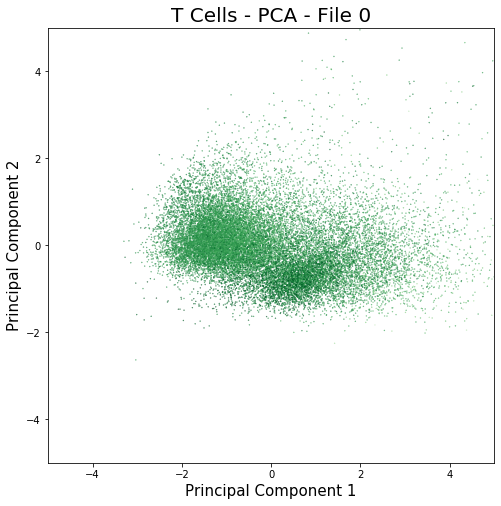

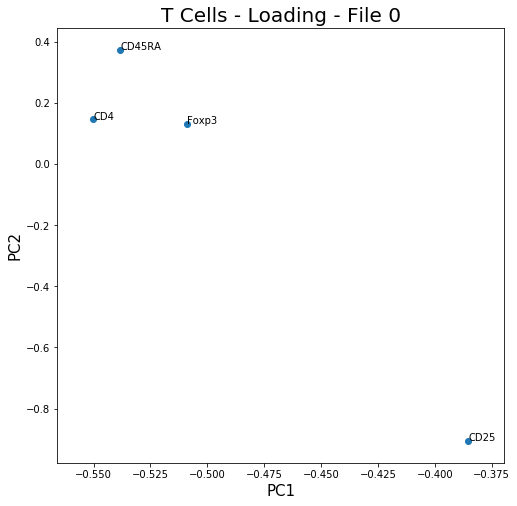

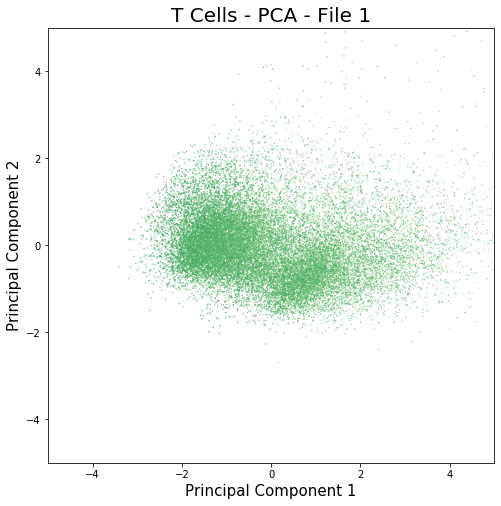

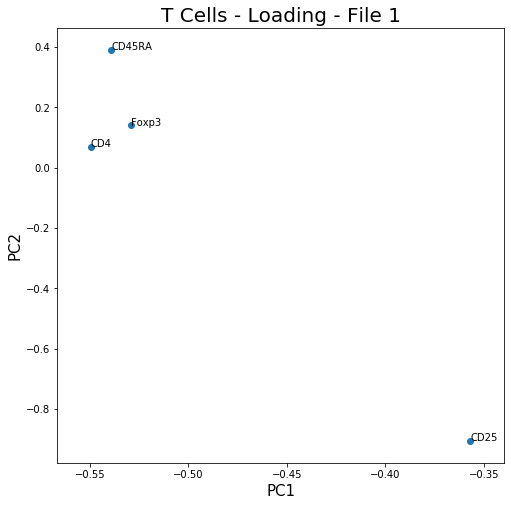

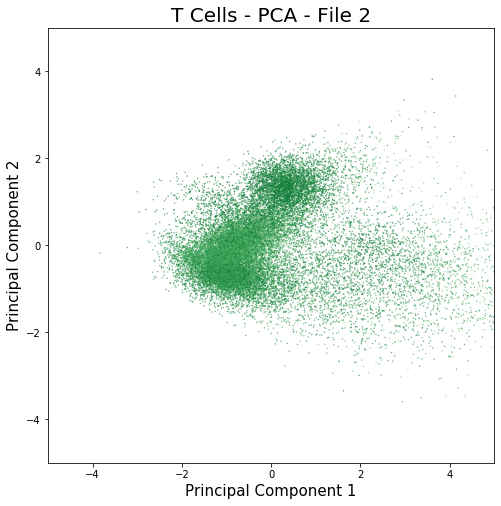

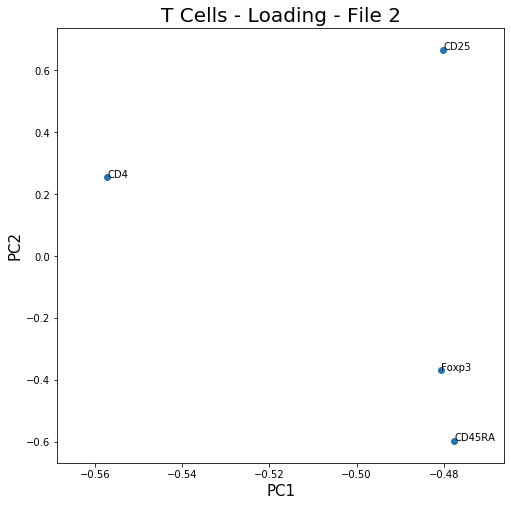

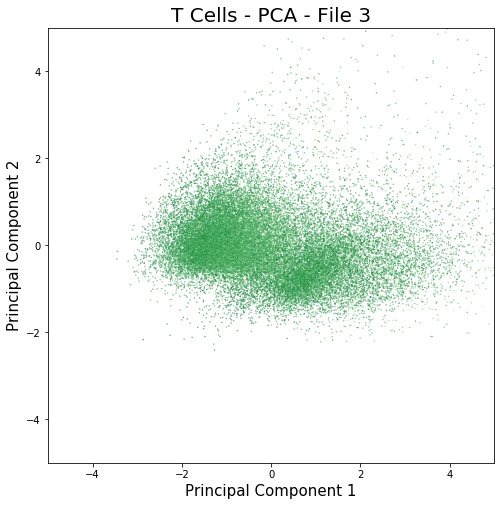

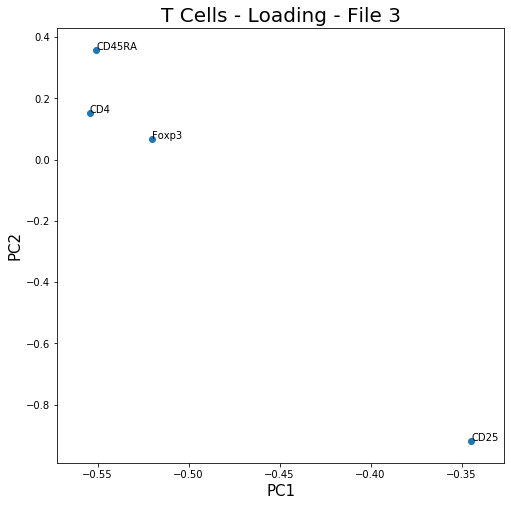

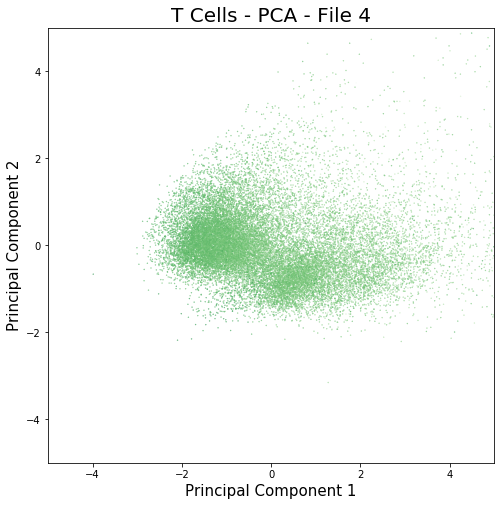

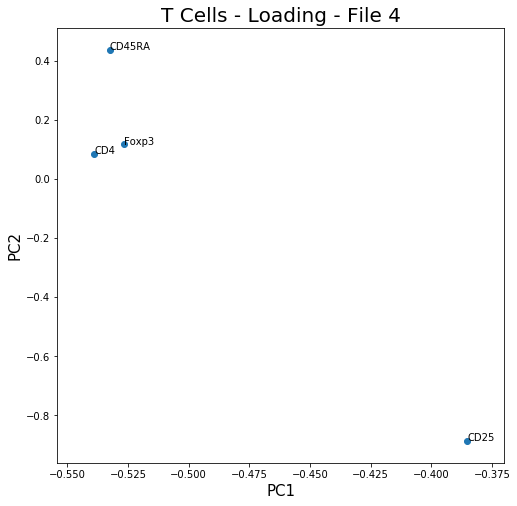

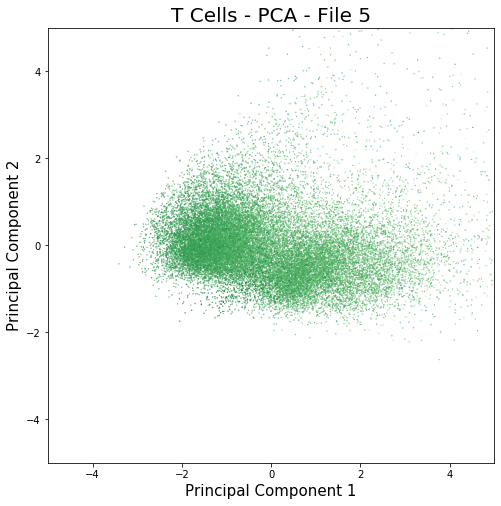

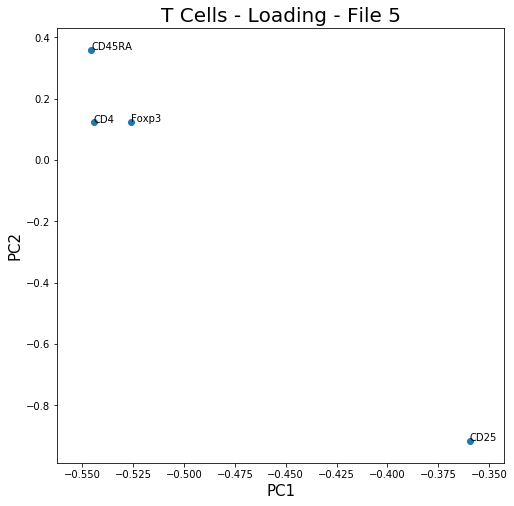

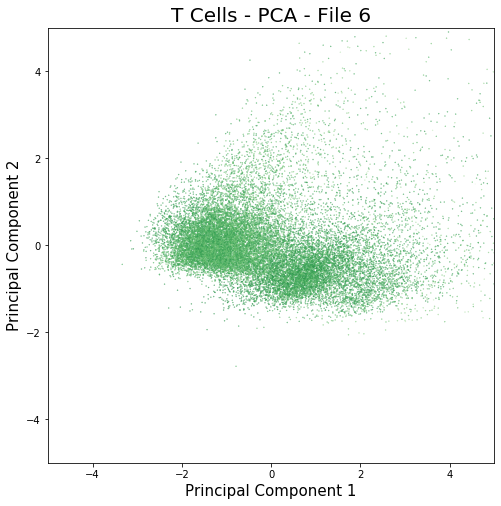

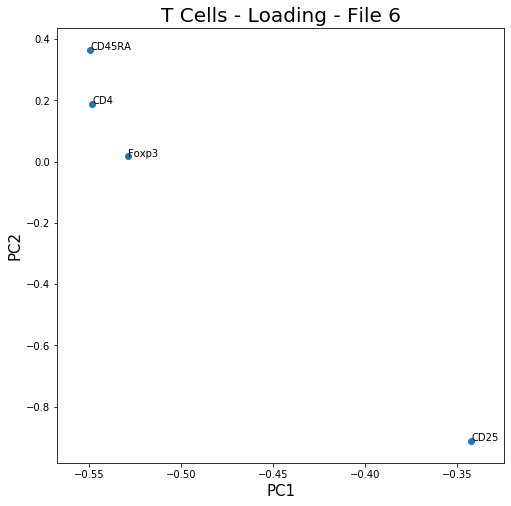

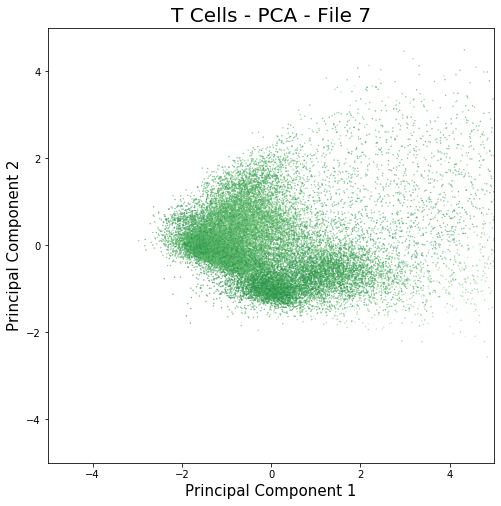

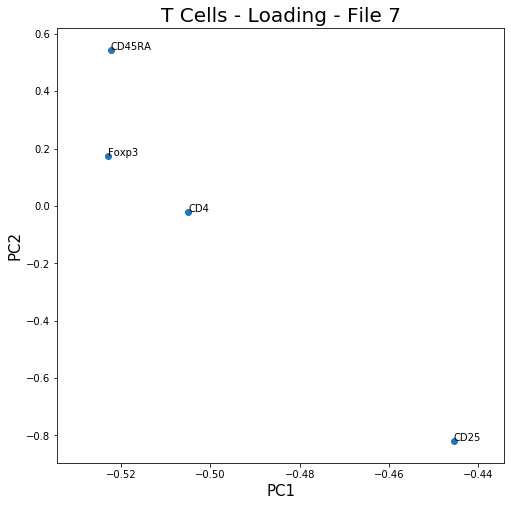

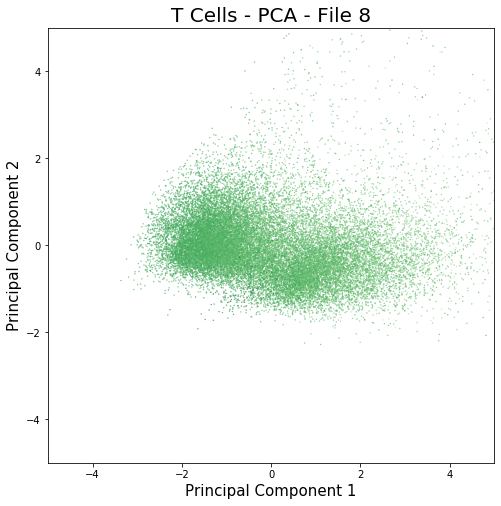

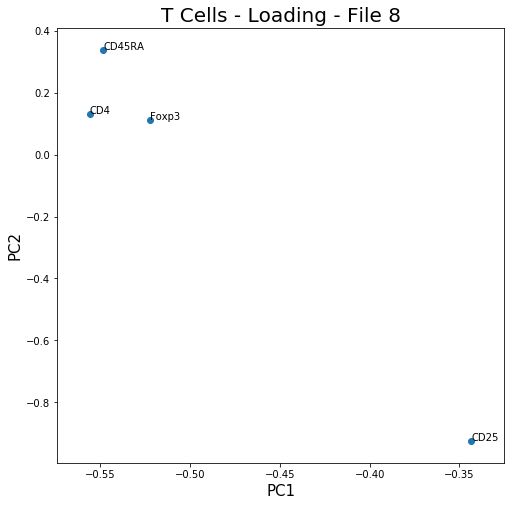

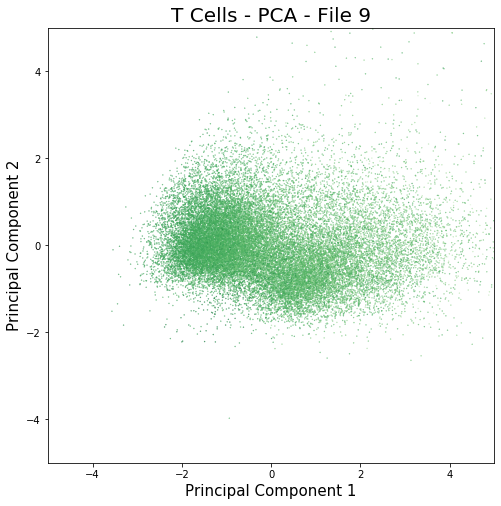

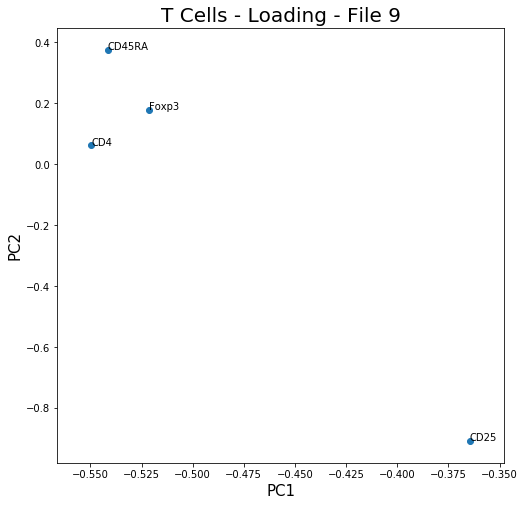

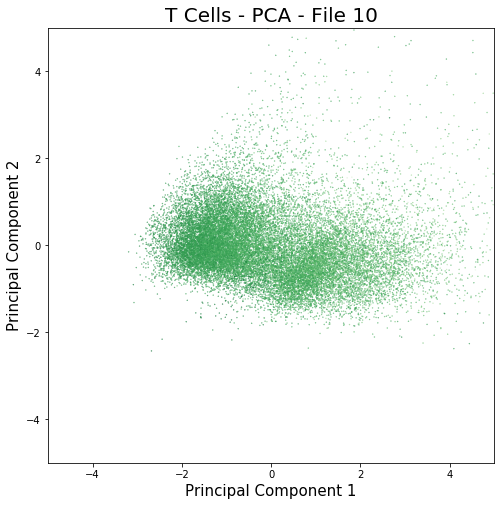

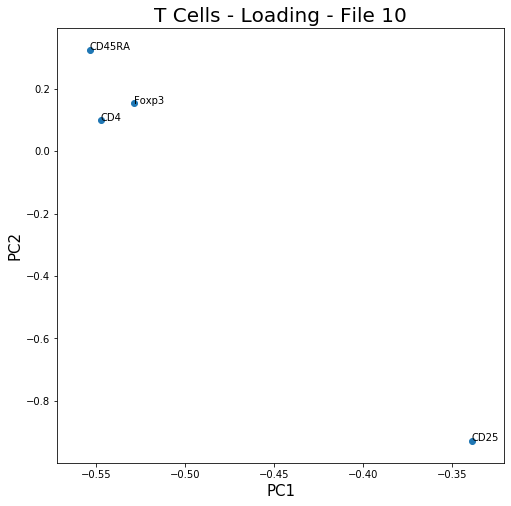

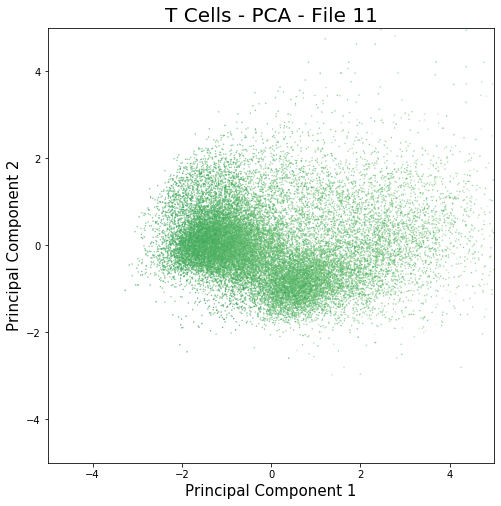

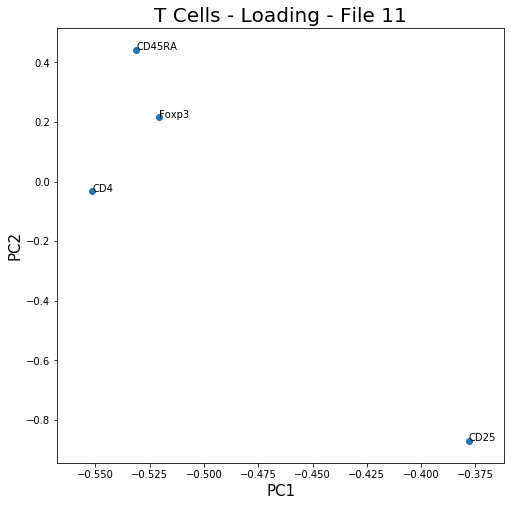

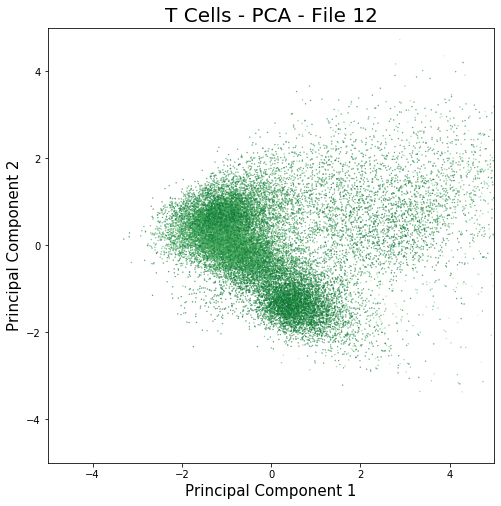

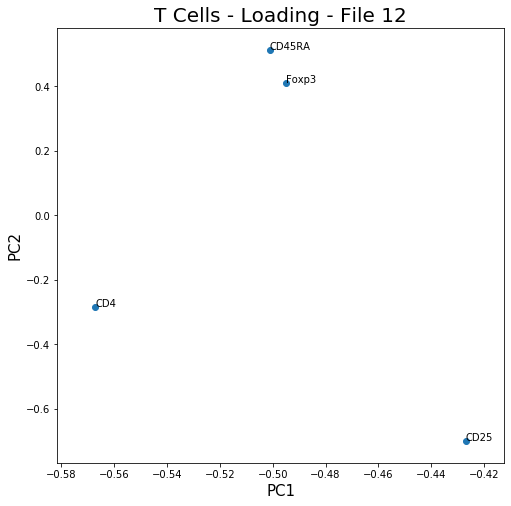

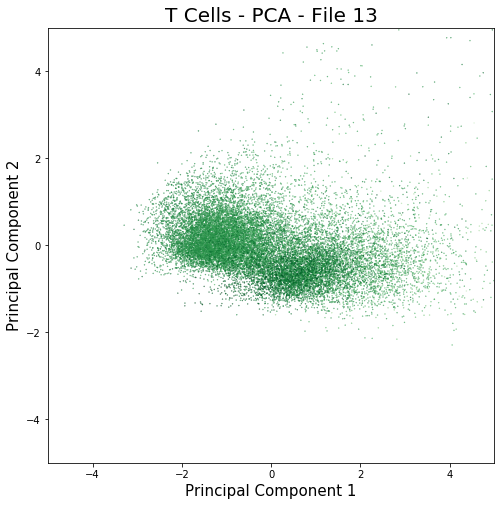

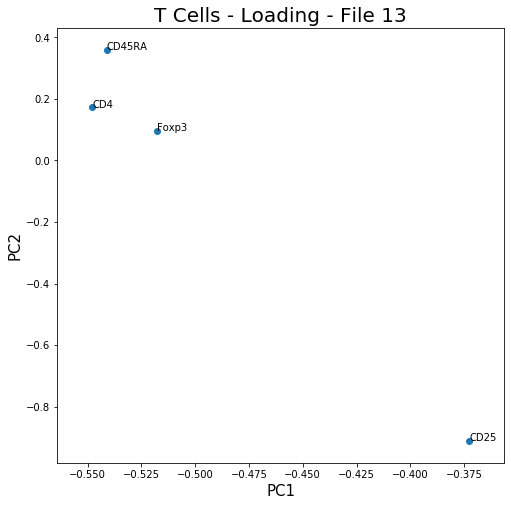

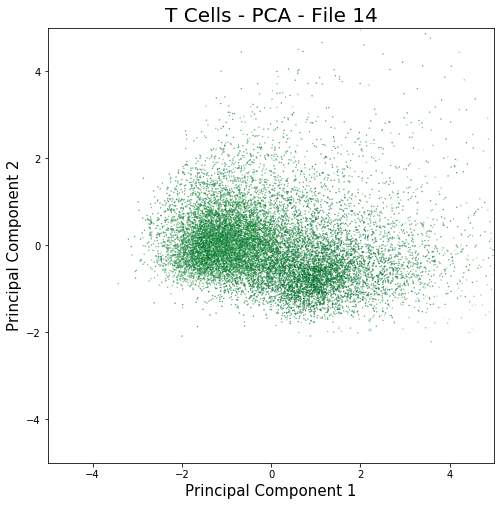

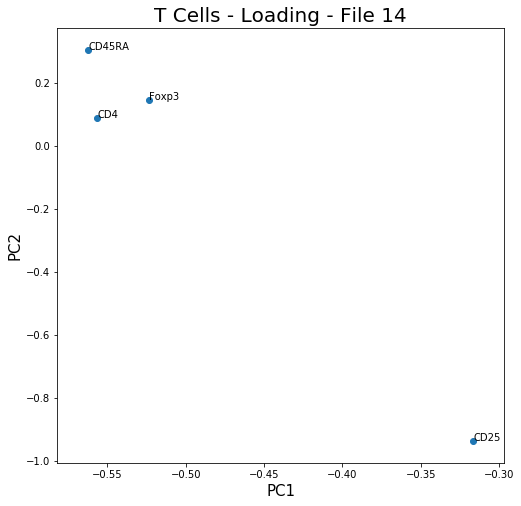

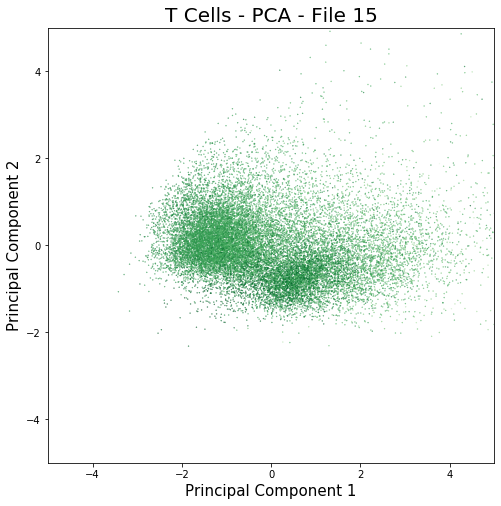

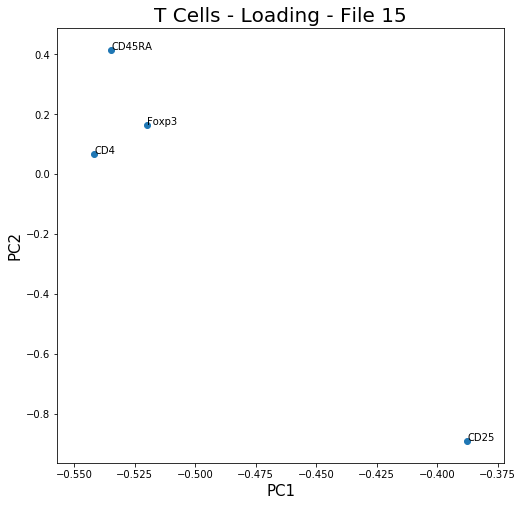

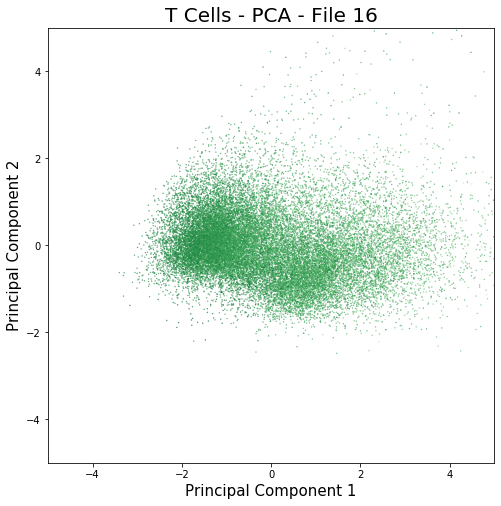

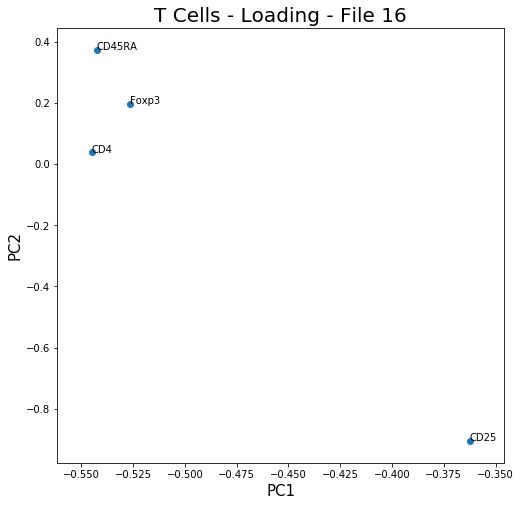

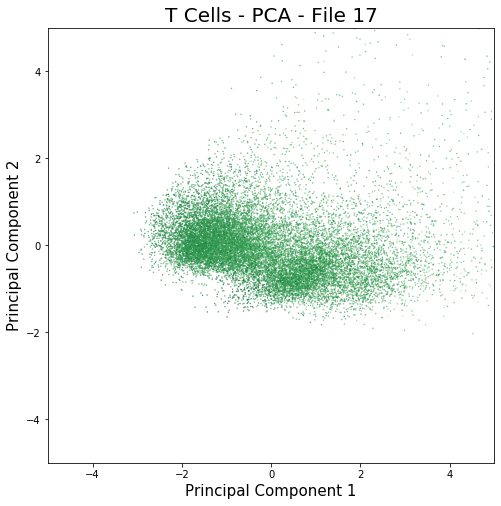

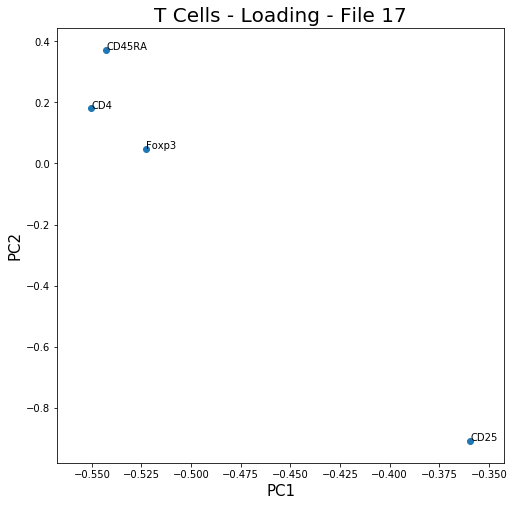

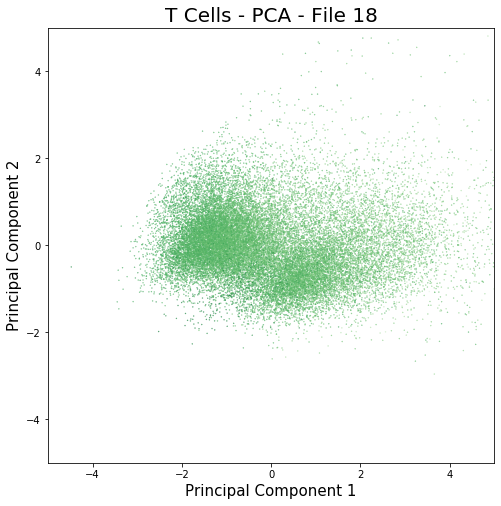

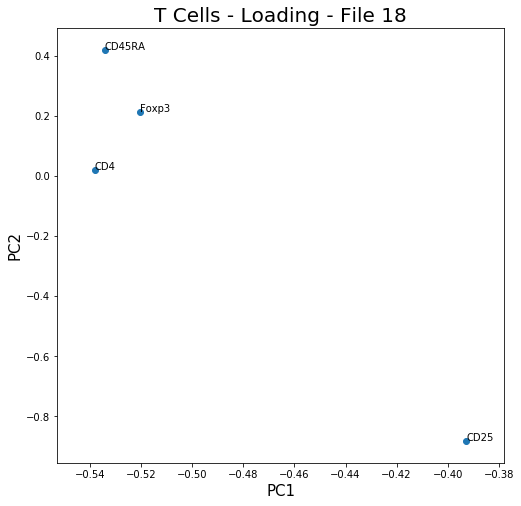

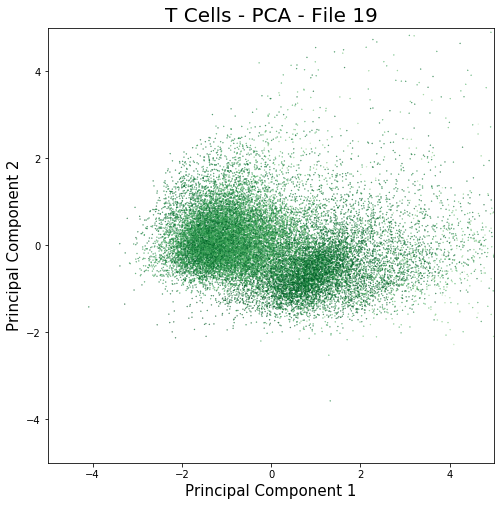

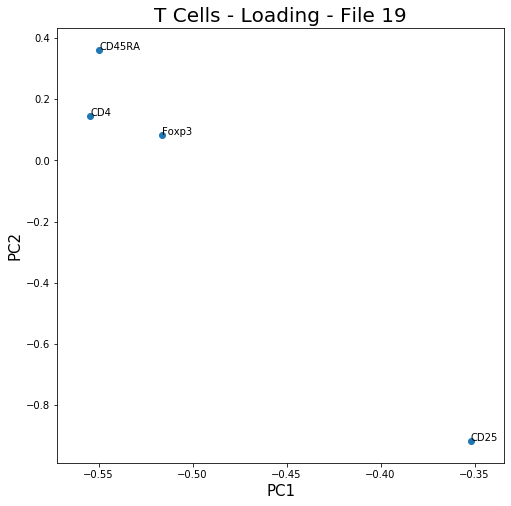

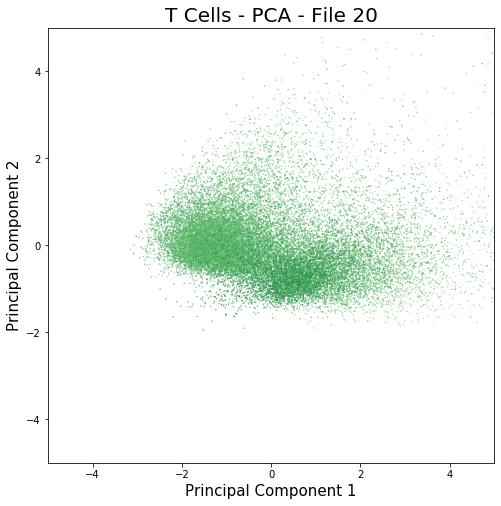

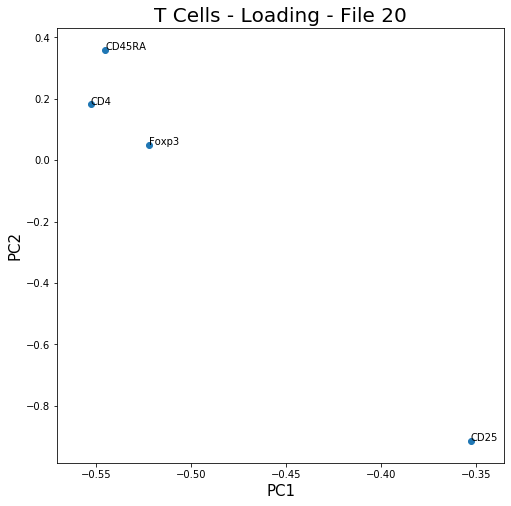

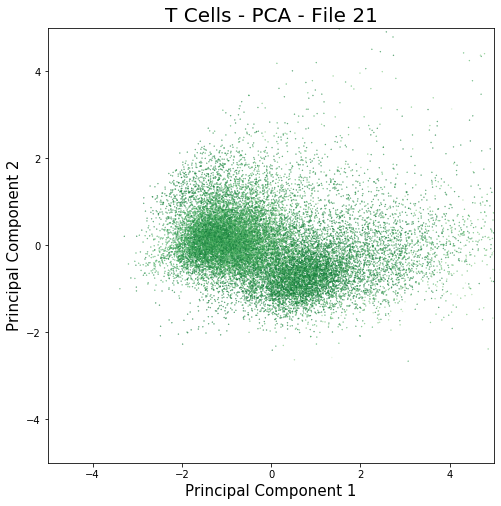

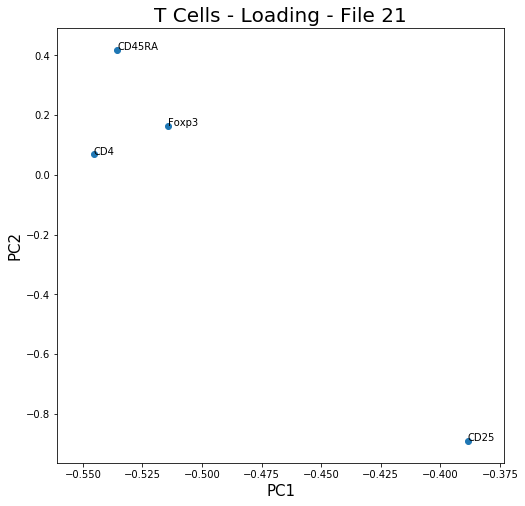

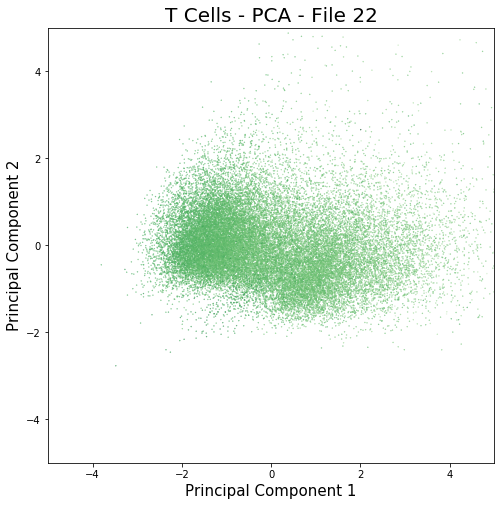

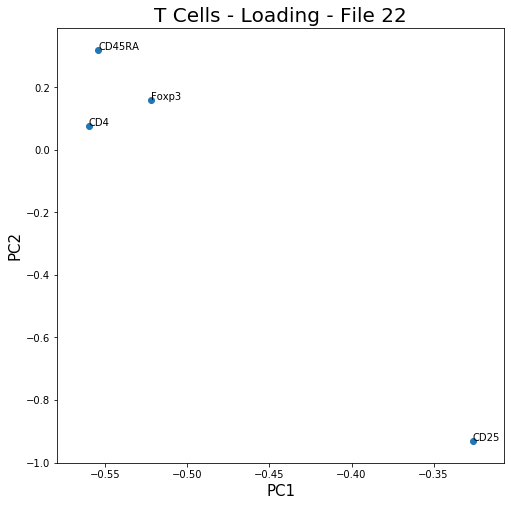

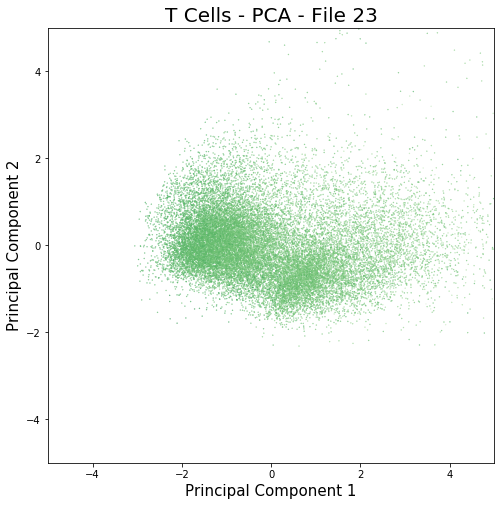

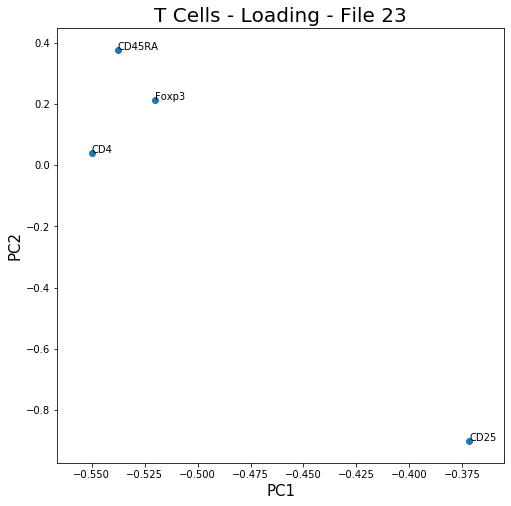

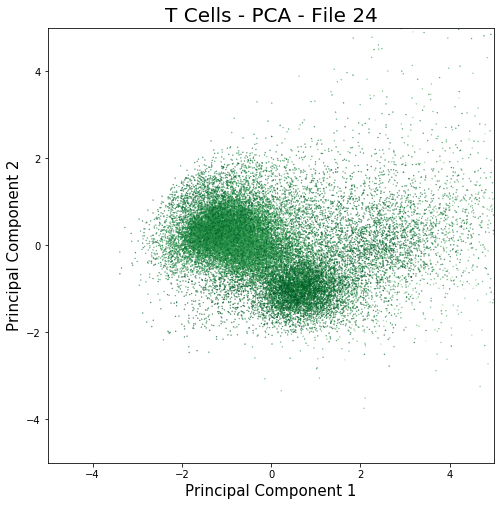

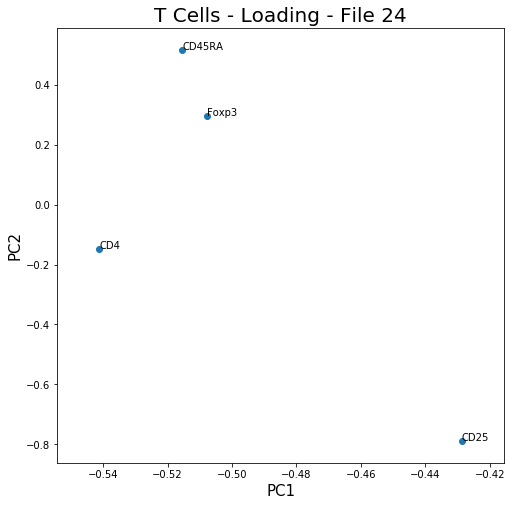

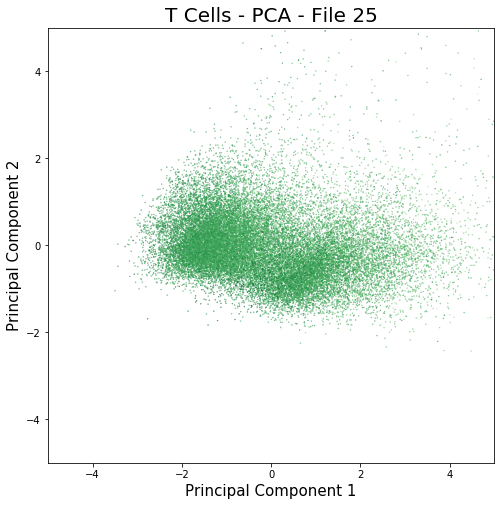

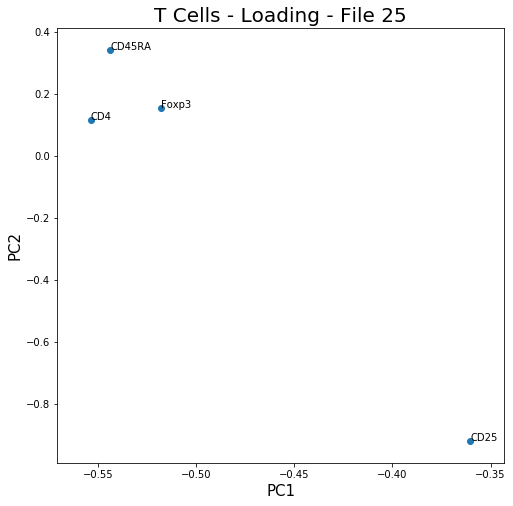

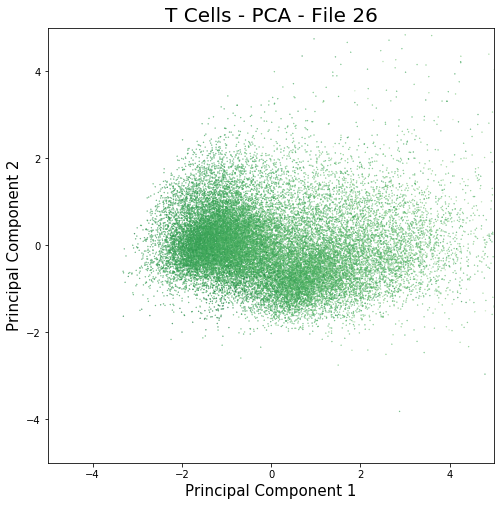

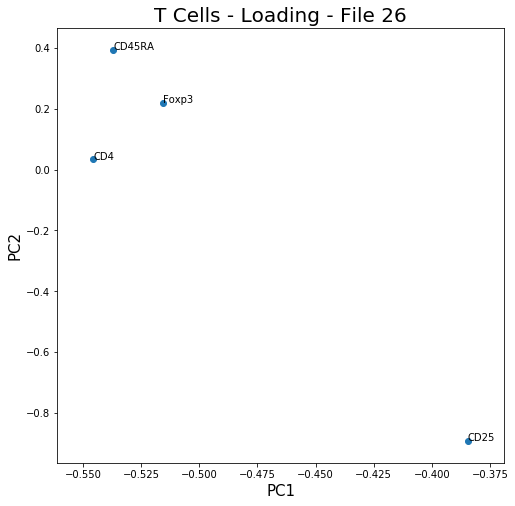

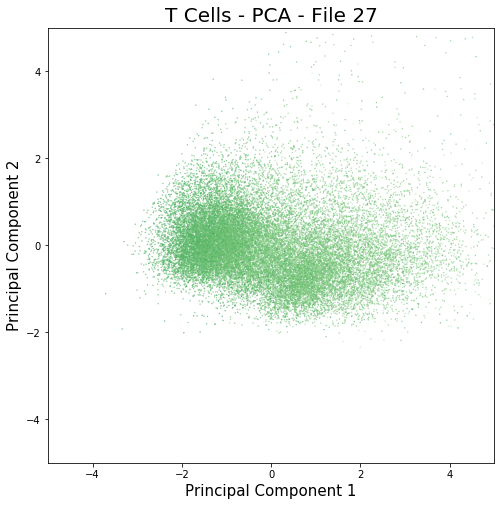

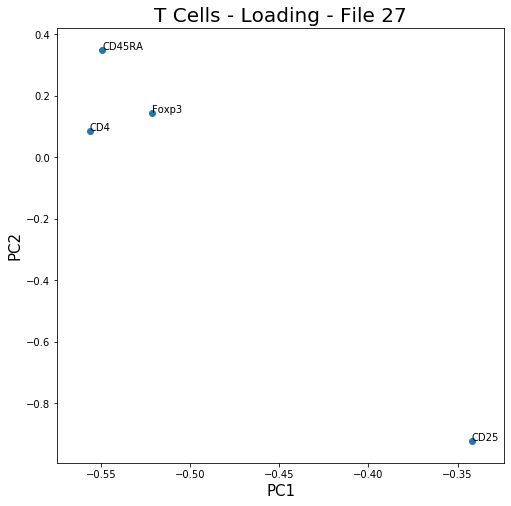

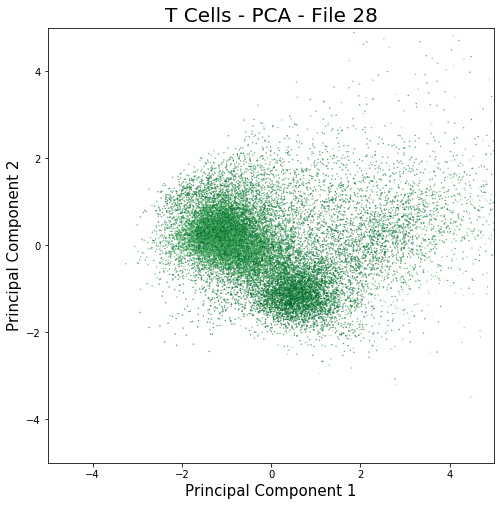

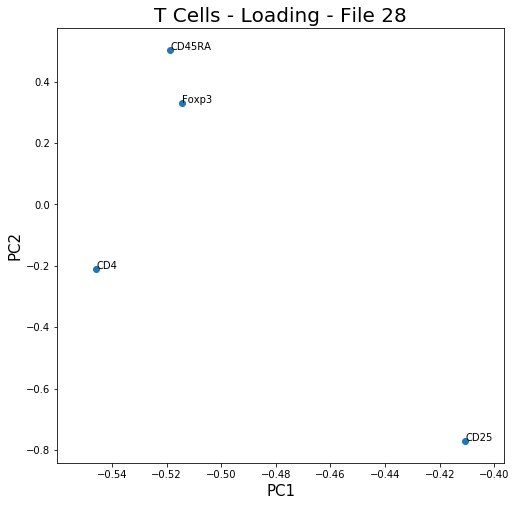

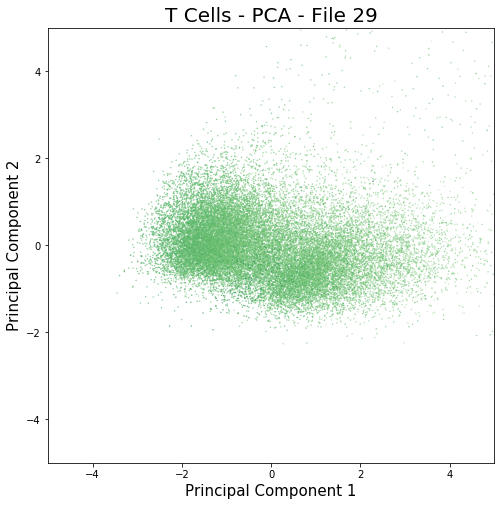

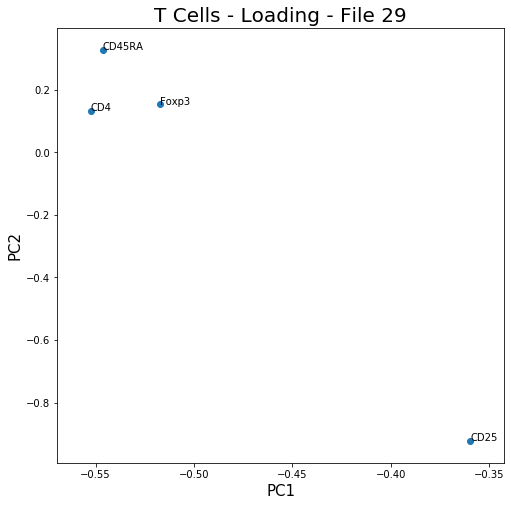

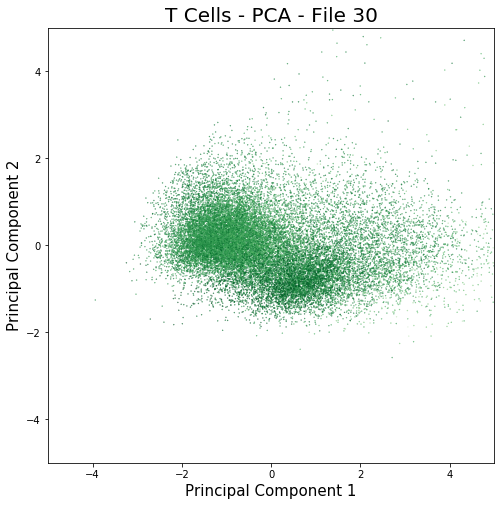

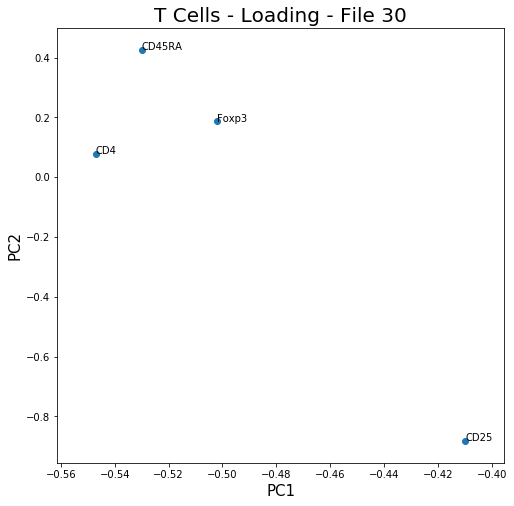

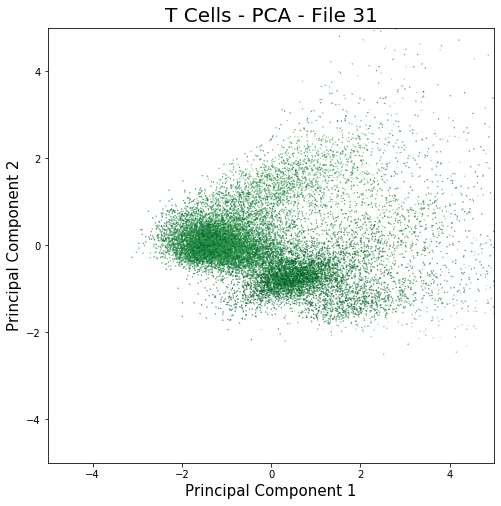

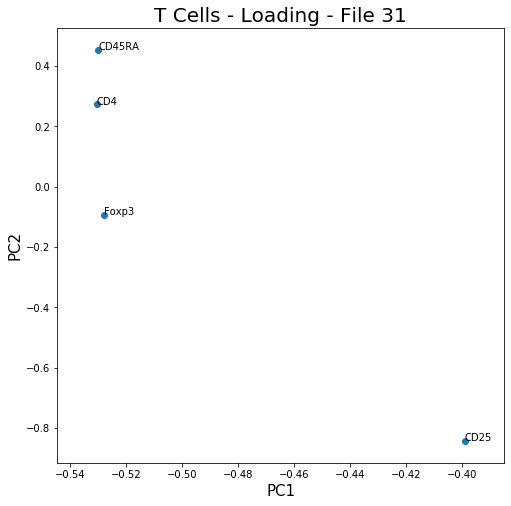

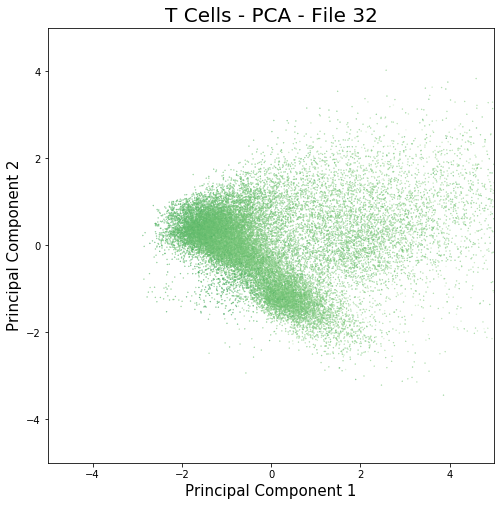

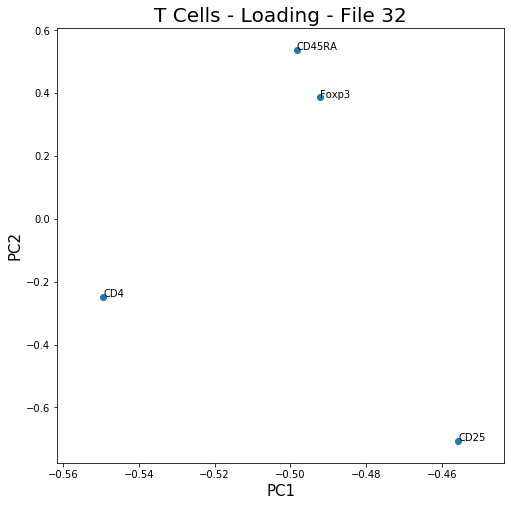

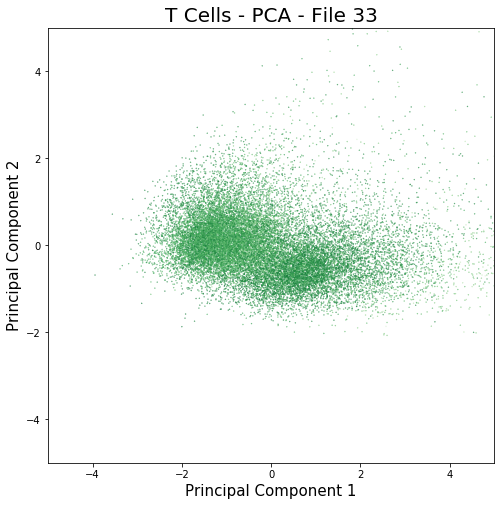

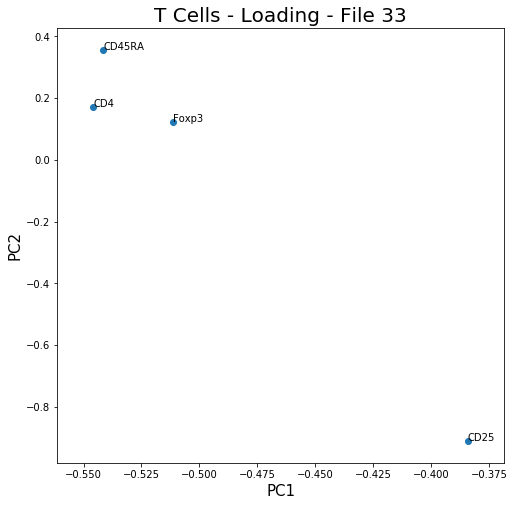

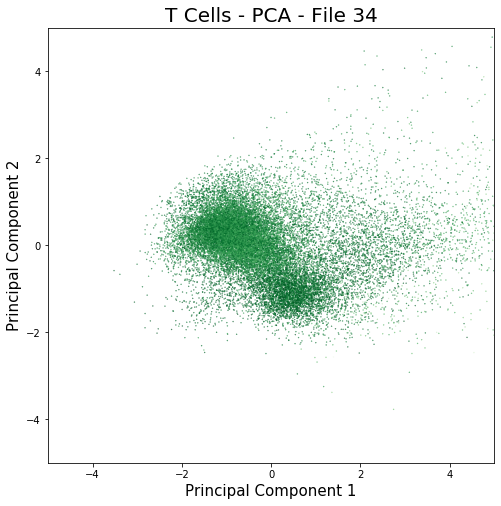

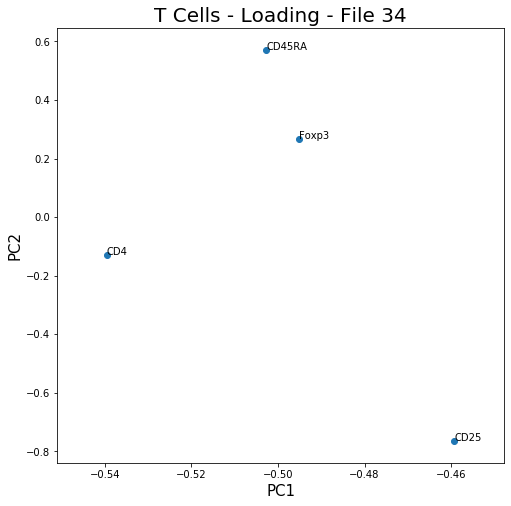

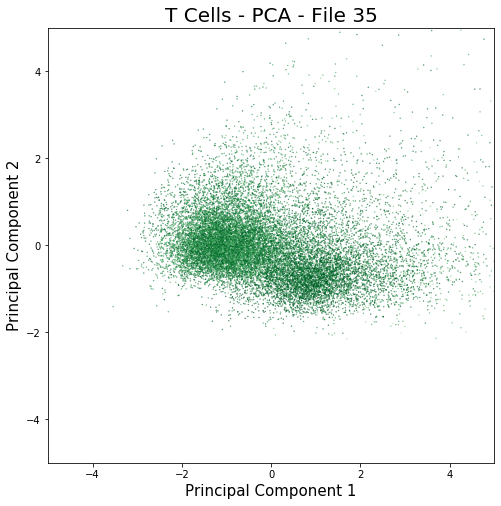

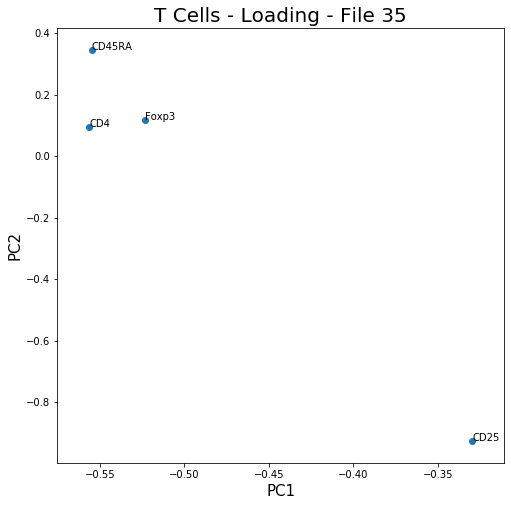

In [2]:
tplate = input('What is the name of the T plate folder?:')
tsample = importF(tplate)

nkplate = input('What is the name of the NK plate folder?:')
nksample = importF(nkplate)

dataT_array, pstatT_array, xfT_array, loadingT_array = pcaAll(tsample, "t")

dataNK_array, pstatNK_array, xfNK_array, loadingNK_array = pcaAll(nksample, "n")
